# Simulating TOD with ducc

In this notebook, we present a <a href="https://gitlab.mpcdf.mpg.de/mtr/ducc">ducc</a>-based pipeline to simulate time-ordered data (TOD) for:
1) an experiment with a LiteBIRD-like scanning strategy;
2) offset detectors (not at boresight);
3) a noise component;
4) a dipole component.

Each of these functionalities is discussed in the corresponding (numbered) section.

## 1) LiteBIRD-like scanning strategy

We have written a slightly modified version of beamconv's <code>scanning.py</code> module (<code>scanning_mod.py</code>) that allows to simulate a LiteBIRD-like scanning strategy. The <code>scanning.py</code> module is based on the <a href="https://github.com/tmatsumu/LB_SYSPL_v4.2">pyScan</a> code written by Tomotake Matsumura (IPMU).

Here we show how to use it.

#### Setting things up
First, we need to import a few modules and define some useful functions for plotting.

<a style="color:Red;">TODO: eventually remove qpoint</a>

In [84]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import healpy as hp
import time
S
import pysm3
import pysm3.units as u

import ducc0
import mueller_convolver
import scanning_mod

#TODO: eventually remove qpoint
import qpoint as qp

# setting up some plotting-related stuff
plt.rcParams.update({
    "font.size":10.95,
    "text.usetex":True,
    "font.family":"serif", 
    "font.serif":"cm"
    })

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('magma')
new_cmap = truncate_colormap(cmap, 0.2, 1)

#### Preparing input maps
We generate I, Q and U input maps from some pysm sky model. <a style="color:Red;">TODO: eventually use WP3's sky model. Also, implement transformation in ecliptic coordinates.</a>

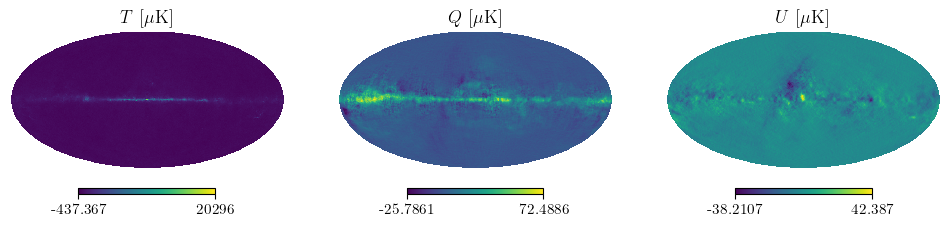

In [85]:
nside = 128
npix = 12*nside**2
lmax = 2*nside

sky = pysm3.Sky(nside=nside, preset_strings=["a1", "d1", "f1", "s1", "c1"], output_unit="uK_CMB")
nu = 140 

# generate input alm and maps
maps_pysm = sky.get_emission(nu * u.GHz)
slm = hp.map2alm(maps_pysm, lmax=lmax)
maps_temp = hp.alm2map(slm,nside=nside)

# plotting input maps
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))
plt.axes(ax1) 
hp.mollview(maps_temp[0], title=r'$T$ [$\mu$K]', hold=True)
plt.axes(ax2)
hp.mollview(maps_temp[1], title=r'$Q$ [$\mu$K]', hold=True)
plt.axes(ax3)
hp.mollview(maps_temp[2], title=r'$U$ [$\mu$K]', hold=True)
plt.show()

Since we plan to [...], we must transform the input maps in ecliptic coordinates. <a style="color:Red;">TODO: write something that makes sense.</a>

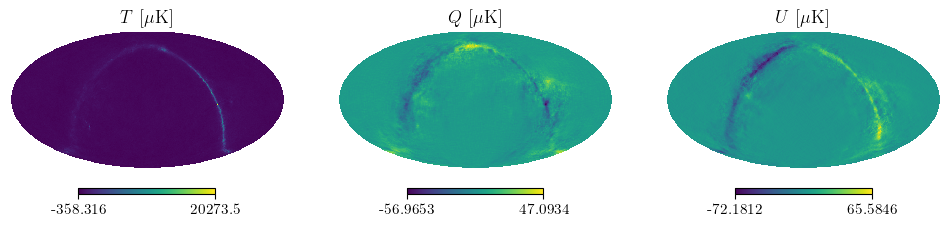

In [86]:
r = hp.Rotator(coord=['G','E'])
maps = r.rotate_map_alms(maps_temp)

# plotting input maps
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))
plt.axes(ax1) 
hp.mollview(maps[0], title=r'$T$ [$\mu$K]', hold=True)
plt.axes(ax2)
hp.mollview(maps[1], title=r'$Q$ [$\mu$K]', hold=True)
plt.axes(ax3)
hp.mollview(maps[2], title=r'$U$ [$\mu$K]', hold=True)
plt.show()

Then, we compute the spherical harmonics coefficients from the input maps.

In [87]:
slm = hp.map2alm(maps)

#### Setting up ducc

First, we define a simple Gaussian beam to scan the sky. More complex beams can be fed to the code as $b_{\ell m}$ spherical harmonic coefficients.

In [88]:
def nalm(lmax, mmax):
    return ((mmax+1)*(mmax+2))//2 + (mmax+1)*(lmax-mmax)

def make_full_random_alm(lmax, mmax, rng):
    res = rng.uniform(-1., 1., (4, nalm(lmax, mmax))) \
     + 1j*rng.uniform(-1., 1., (4, nalm(lmax, mmax)))
    # make a_lm with m==0 real-valued
    res[:, 0:lmax+1].imag = 0.
    ofs=0
    # components 1 and 2 are spin-2, fix them accordingly
    spin=2
    for s in range(spin):
        res[1:3, ofs:ofs+spin-s] = 0.
        ofs += lmax+1-s
    return res

def get_gauss_beam_from_beamconv(fwhm, lmax):
    import beamconv
    blmT, blmm2 = beamconv.tools.gauss_blm(fwhm*180*60/np.pi, lmax, pol=True)
    res = np.zeros((4,blmT.shape[0]), dtype=np.complex128)
    blmE, blmB = beamconv.tools.spin2eb(blmm2, blmm2*0, spin=2)
    res[0] = blmT
    res[1] = blmE
    res[2] = blmB
    res[3] = blmT  # correct?
    return res

def blm_gauss_new(fwhm, lmax, pol=False):
    fwhm = float(fwhm)
    lmax = int(lmax)
    pol = bool(pol)
    mmax = 2 if pol else 0
    ncomp = 3 if pol else 1
    nval = hp.Alm.getsize(lmax, mmax)

    if mmax > lmax:
        raise ValueError("lmax value too small")

    blm = np.zeros((ncomp, nval), dtype=np.complex128)
    sigmasq = fwhm * fwhm / (8 * np.log(2.0))

    for l in range(lmax+1):
        blm[0, hp.Alm.getidx(lmax, l, 0)] = np.exp(-0.5*sigmasq*l*(l+1))

    if pol:
        for l in range(2, lmax+1):
            blm[1, hp.Alm.getidx(lmax, l, 2)] = np.exp(-0.5 * sigmasq * (l*(l+1)-4))
        blm[2] = 1j * blm[1]

    return blm

# blm_gauss_new times sqrt((2*l+1)/(4pi))
def Blm_gauss_new(fwhm, lmax, pol=False):
    blm = blm_gauss_new(fwhm, lmax, pol)
    for l in range(lmax+1):
        blm[0, hp.Alm.getidx(lmax, l, 0)] *= np.sqrt((2*l+1) / (4*np.pi))

    if pol:
        for l in range(2, lmax+1):
            blm[1:3, hp.Alm.getidx(lmax, l, 2)] *= np.sqrt((2*l+1) / (4*np.pi))

    return blm

In [89]:
np.random.seed(10)
rng = np.random.default_rng(np.random.SeedSequence(42))
lmax = 30
kmax = 18

<a style="color:Red;">TODO: eventually use fiducial blm</a>

In [90]:
fwhm_arcmin = 5
fwhm_rad = np.radians(fwhm_arcmin/60)

# completely random beam
blm = make_full_random_alm(lmax, kmax, rng)
# ... or use a Gauss beam
#blmtmp = blm_gauss_new(fwhm_rad, lmax, True)
#blm *= 0
#blm [0:3, 0:blmtmp.shape[1]] = blmtmp

#### Running ducc (external pointings)

We specify the scanning strategy by directly providing the pointings.

In [91]:
ctim0 = 1510000000                    # initial time

duration = 3600*24*7                  # mission duration in s (7 days)
fsamp = 19.1                          # sampling frequency in Hz
nsamp = int(duration*fsamp)           # number of samples

In [92]:
fquat = 1.
nquat = int((duration+1)*fquat)

ctime_quat = ctim0 + np.arange(nquat)/fquat
theta, phi, psi = scanning_mod.ctime2bore(ctime_quat)

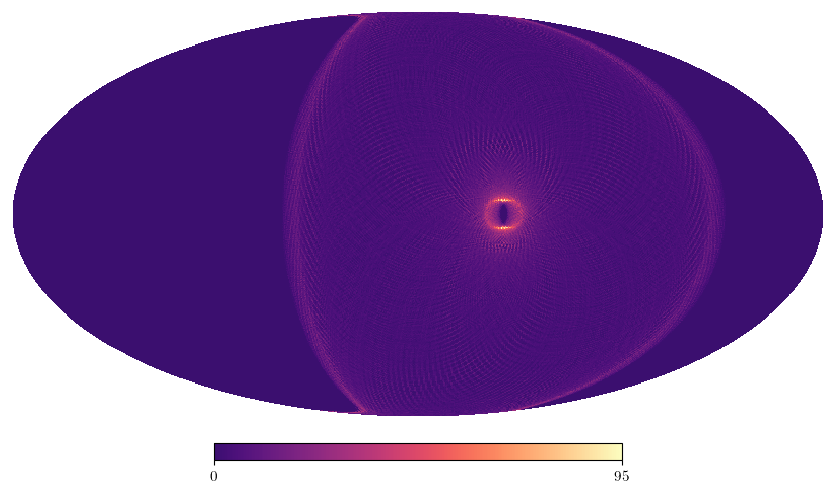

In [93]:
pixs = hp.ang2pix(nside, theta, phi)

hits = np.bincount(pixs)
        
hp.mollview(hits, cmap=new_cmap, title='')
plt.show()

In [94]:
q_bore = np.empty((nquat, 4))

for i in np.arange(nquat):
    q_bore[i] = ducc0.misc.ptg2quat(np.array([theta[i],phi[i],psi[i]]))

In [127]:
off_quat = np.array([0.9200679609994841,-0.03704627596838304, 0.08283588163313664, 0.3811046277509462])
#off_quat = np.array([0.,0.,0.,1.])

new_quats = np.empty((nsamp,4))

pp = ducc0.pointingprovider.PointingProvider(t0=ctim0, freq=fquat, quat=q_bore, nthreads=1)
rotated_quats = pp.get_rotated_quaternions(t0=ctim0, freq=fsamp, rot=off_quat, rot_left=False, out=new_quats)

rotated_pointings = np.empty((nsamp, 3))

for i in np.arange(nsamp):
    rotated_pointings[i] = ducc0.misc.quat2ptg(rotated_quats[i])

In [128]:
print(off_quat)

[ 0.92006796 -0.03704628  0.08283588  0.38110463]


In [129]:
theta = scanning_mod.wraparound_npi(rotated_pointings[:,0],1)

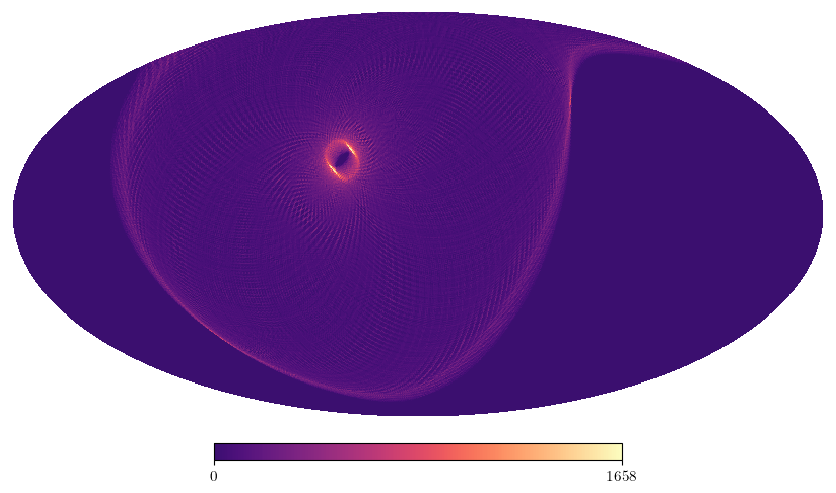

In [130]:
pixs = hp.ang2pix(nside, theta, rotated_pointings[:,1])

hits = np.bincount(pixs,minlength=npix)
        
hp.mollview(hits, cmap=new_cmap, title='')
plt.show()

<p style="color:Red;">TODO: implement this step with ducc tools:</p>

In [28]:
q_bore = np.empty((nquat, 4))

for i in np.arange(nquat):
    q_bore[i] = ducc0.misc.ptg2quat(np.array([theta[i],phi[i],psi[i]]))

In [34]:
off_quat = np.roll(np.array([0.009165646421980997, 0.09071095143135842, 0.0, 0.9958350838447524]),3)
off_quat = np.roll(np.array([1., 0., 0., 0.]),3)

nsamp_new = int(nsamp) #full duration!

new_quats = np.empty((nsamp_new,4))

pp = ducc0.pointingprovider.PointingProvider(t0=ctim0, freq=fquat, quat=q_bore, nthreads=1)
rotated_quats = pp.get_rotated_quaternions(t0=ctim0, freq=fsamp, rot=off_quat, rot_left=False, out=new_quats)

rotated_pointings = np.empty((nsamp, 3))

for i in np.arange(nsamp):
    rotated_pointings[i] = ducc0.misc.quat2ptg(rotated_quats[i])

In [35]:
nside=32

#TODO: avoid for loop
pixs = hp.ang2pix(nside, rotated_pointings[0], rotated_pointings[1])

hits = np.empty(npix)

for p in np.arange(npix):
    hits[p] = np.count_nonzero(pixs == p)
        
hp.mollview(hits, cmap=new_cmap, title='')
plt.show()

ValueError: THETA is out of range [0,pi]

In [14]:
temp_ptg = Q.quat2radecpa(rotated_pointings)

print(np.shape(temp_ptg))

ptg = np.empty((nsamp_new,3))

# From (ra,dec) to (theta,phi) convention
# Also, all angles are converted in radians
ptg[:,0] = scanning_mod.wraparound_npi(np.radians(temp_ptg[0] + 180),1)
ptg[:,1] = scanning_mod.wraparound_npi(np.radians(temp_ptg[1] + 90),2)
ptg[:,2] = np.radians(temp_ptg[2])

(3, 11551680)


In [15]:
# completely random Mueller matrix
mueller = np.random.uniform(-1,1,size=(4,4))
#mueller[1:3,0]=mueller[1:3,-1] = 0
#mueller[0,2]=mueller[2,0] = 0

#TODO: write something reasonable
hwp_angles = np.random.uniform(0,2*np.pi,size=(nsamp_new,))  # alpha

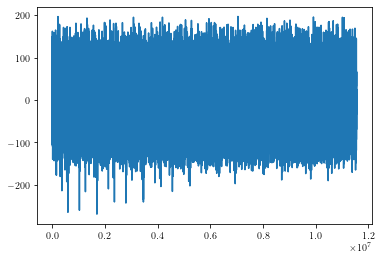

10.02760934829712


In [16]:
start = time.time()

# Now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=slm,
    blm=blm,
    mueller=mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=ptg, alpha=hwp_angles)


plt.plot(signal_muellerconvolver, label="MuellerConvolver")
#plt.legend()
plt.show()

print(time.time()-start)